#### Notebook showing examples from Loess python package

Just copied and pasted the examples from [Michele Cappellari's loess package](http://www-astro.physics.ox.ac.uk/~mxc/software/#loess) into a notebook (stripped of function names, etc)

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs

from loess.loess_1d import loess_1d
from loess.loess_2d import loess_2d

import physics

CPU times: user 155 ms, sys: 3.37 ms, total: 159 ms
Wall time: 158 ms


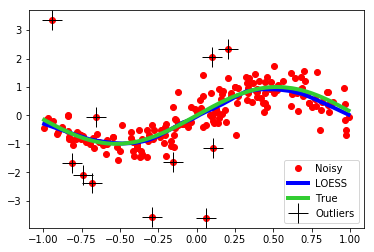

In [2]:
"""
Usage example for loess_1d (site-packages/loess/examples/test_loess_1d.py)

"""
n = 200
np.random.seed(123)
x = np.random.uniform(-1, 1, n)
x.sort()

y = np.sin(3*x)
sigy = 0.4
yran = np.random.normal(y, sigy)

nbad = int(n*0.1) # 10% outliers
w = np.random.randint(0, n, nbad)  # random indices from 0-n
yran[w] += np.random.normal(0, 5*sigy, nbad)

%time xout, yout, weigts = loess_1d(x, yran, frac=0.3)

w = weigts < 0.34  # identify outliers
plt.clf()
plt.plot(x, yran, 'ro', label='Noisy')
plt.plot(xout, yout, 'b', linewidth=4, label='LOESS')
plt.plot(x, y, color='limegreen', linewidth=4, label='True')
plt.plot(x[w], yran[w], '+k', ms=20, label='Outliers')
plt.legend(loc='lower right')

CPU times: user 118 ms, sys: 256 µs, total: 118 ms
Wall time: 120 ms


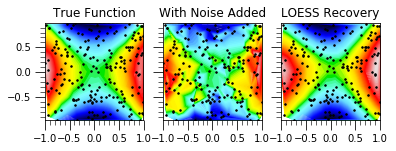

In [3]:
from plotbin.plot_velfield import plot_velfield

"""
Usage example for loess_2d (site-packages/loess/examples/test_loess_2d.py)

"""
n = 200
x = np.random.uniform(-1,1,n)
y = np.random.uniform(-1,1,n)
z = x**2 - y**2
sigz = 0.2
zran = np.random.normal(z, sigz)

%time zout, wout = loess_2d(x, y, zran)

plt.clf()
plt.subplot(131)
plot_velfield(x, y, z)
plt.title("True Function")

plt.subplot(132)
plot_velfield(x, y, zran)
plt.title("With Noise Added")
plt.tick_params(labelleft=False)

plt.subplot(133)
plot_velfield(x, y, zout)
plt.title("LOESS Recovery")
plt.tick_params(labelleft=False)

In [ ]:
sigz = 0.2
for n in [250, 500, 1000, 2000, 4000, 8000, 11600]:
    x = np.random.uniform(-1,1,n)
    y = np.random.uniform(-1,1,n)
    z = x**2 - y**2
    zran = np.random.normal(z, sigz)

    %time zout, wout = loess_2d(x, y, zran)

In [ ]:
n = [250, 500, 1000, 2000, 4000, 8000, 11600]
t = [0.134, 0.312, 0.783, 2.10, 6.31, 21.9, 44.2]
logn = np.log10(n)
logt = np.log10(t)

# Trying to find logt = m*logn + b => t = 10^b * n^m
m = (logt[-1] - logt[-2])/(logn[-1] - logn[-2])
b = logt[-1] - m*logn[-1]
def t_guess(n):
    return (10**b)*(n**m)

plt.loglog(n, t)
plt.loglog(n, t_guess(n))
    
print("It could take {:.2f} seconds for gx1v7 grid".format(t_guess(384*320)))

In [ ]:
class MidPointNorm(colors.Normalize):
    """ class that computes a midpont? """
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        colors.Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = np.ma.asarray(value)
            val = 2 * (val-0.5)
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0:
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint



In [ ]:
"""
Update loess_2d example (site-packages/loess/examples/test_loess_2d.py) for global data

"""
gx1v7_ds = xr.open_dataset("/Users/mlevy/MARBL_data/POP_hist.nc", decode_times=False)

lon = np.reshape(gx1v7_ds['TLONG'].values * np.pi/180., 384*320)
lat = np.reshape(gx1v7_ds['TLAT'].values * np.pi/180., 384*320)
ssh = np.reshape(gx1v7_ds['SSH'].values * np.pi/180., 384*320)
clon = 1.5*np.pi
clat = 0.0
r = np.arccos(np.sin(clat)*np.sin(lat) + np.cos(clat)*np.cos(lat)*np.cos(lon - clon))
R = 1.0/3.0
bell = np.cos(np.pi*r/R)
sigz = 0.2
bell_noise = np.random.normal(bell, sigz)
print("Starting loess_2d...")
%time bell_fixed, wbell = loess_2d(lon, lat, bell_noise)
%time ssh_fixed, wssh = loess_2d(lon, lat, ssh)


In [ ]:
%%time

print("Reshape all data...")
lon = np.reshape(lon, (384,320))
lat = np.reshape(lat, (384,320))
bell = np.reshape(bell, (384,320))
bell_noise = np.reshape(bell_noise, (384,320))
bell_fixed = np.reshape(bell_fixed, (384,320))

In [ ]:
%%time

print("Starting plots...")
nlev = 10
clevels = [1.0*lev/nlev for lev in range(-nlev, nlev+1)]
print(clevels)
fig= plt.figure(figsize=(12,8));
ax00 = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf00 = ax00.contourf(lon, lat, bell, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', norm=MidPointNorm(0), extend='both')
ax01 = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf01 = ax01.contourf(lon, lat, bell_noise, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', norm=MidPointNorm(0), extend='both')
ax11 = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf11 = ax11.contourf(lon, lat, bell_fixed, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', norm=MidPointNorm(0), extend='both')
                     
fig.subplots_adjust(hspace=0.45, wspace=0.02, right=0.9)
cax = plt.axes((0.93, 0.15, 0.02, 0.7))
fig.colorbar(cf00, cax=cax)

In [ ]:
%%time

print("Starting plots...")
nlev = 10
clevels = [200.0*lev/nlev for lev in range(-nlev, nlev+1)]
print(clevels)
fig= plt.figure(figsize=(12,4));
ax00 = fig.add_subplot(2, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf00 = ax00.contourf(lon, lat, ssh, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', norm=MidPointNorm(0), extend='both')
ax01 = fig.add_subplot(2, 1, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf01 = ax01.contourf(lon, lat, ssh_fixed, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', norm=MidPointNorm(0), extend='both')
